In [1]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import datetime
import os
from pprint import pprint
import matplotlib.pyplot as plt
import time
import vectorbt as vbt
from time import time
import helpers as pth

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

plt.style.use("classic")
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = [-1000000000, 1000000000]

/Users/e1211913/miniconda3/envs/trading/lib/python3.12/site-packages/telegram/utils/request.py:54: UserWarning: python-telegram-bot wasn't properly installed. Please refer to README.rst on how to properly install.
  warnings.warn(


In [2]:
I = pth.load_instruments()

### Information Coefficient

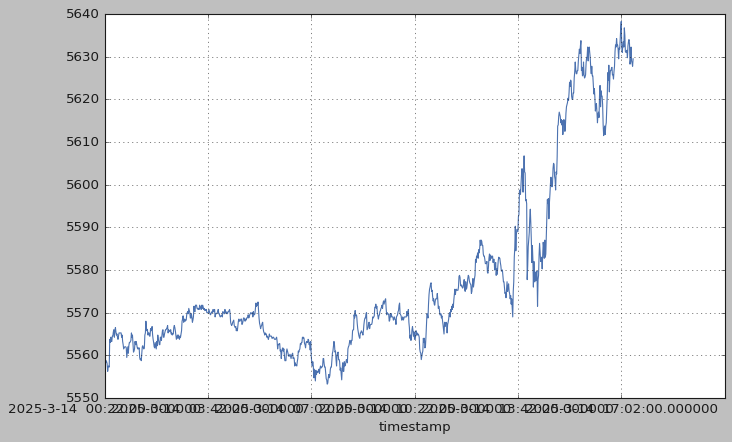

In [3]:
series = I["MES"].iloc[-1024:].close
series.plot()
plt.show()

In [4]:
series

timestamp
2025-3-14  00:22:00.000000    5558.75
2025-3-14  00:23:00.000000    5558.50
2025-3-14  00:24:00.000000    5558.25
2025-3-14  00:25:00.000000    5558.75
2025-3-14  00:26:00.000000    5558.50
                               ...   
2025-3-14  17:21:00.000000    5632.25
2025-3-14  17:22:00.000000    5629.00
2025-3-14  17:23:00.000000    5628.50
2025-3-14  17:24:00.000000    5627.75
2025-3-14  17:25:00.000000    5629.50
Name: close, Length: 1024, dtype: float64

In [65]:
series.

TypeError: unstack_to_df() got an unexpected keyword argument 'level'

In [2]:
# TODO: explain and revise the Information Coefficient
# TODO: ? look into kalman filter for denoising time series
# TODO: add examples of the IR that show 100% predictive power 0% predictive power and something in between
# TODO: perform t-tests for the 3 examples above.